![Cabec%CC%A7alho_notebook.png](cabecalho_notebook.png)

# Classificação de Atividade Humana com PCA

Vamos trabalhar com a base da demonstração feita em aula, mas vamos explorar um pouco melhor como é o desempenho da árvore variando o número de componentes principais.

In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.tree import DecisionTreeClassifier

from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay


filename_features = "/content/features.txt"
filename_labels = "/content/activity_labels.txt"

filename_subtrain = "/content/subject_train.txt"
filename_xtrain = "/content/X_train.txt"
filename_ytrain = "/content/y_train.txt"

filename_subtest = "/content/subject_test.txt"
ffilename_xtest = "/content/X_test.txt"
filename_ytest = "/content/y_test.txt"

features = pd.read_csv(filename_features, header=None, names=['nome_var'], squeeze=True, sep="#")
labels = pd.read_csv(filename_labels, delim_whitespace=True, header=None, names=['cod_label', 'label'])

subject_train = pd.read_csv(filename_subtrain, header=None, names=['subject_id'], squeeze=True)
X_train = pd.read_csv(filename_xtrain, delim_whitespace=True, header=None)
y_train = pd.read_csv(filename_ytrain, header=None, names=['cod_label'])

subject_test = pd.read_csv(filename_subtest, header=None, names=['subject_id'], squeeze=True)
X_test = pd.read_csv(ffilename_xtest, delim_whitespace=True, header=None)
y_test = pd.read_csv(filename_ytest, header=None, names=['cod_label'])

<ipython-input-45-cc84281960eb>:25: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  features = pd.read_csv(filename_features, header=None, names=['nome_var'], squeeze=True, sep="#")
<ipython-input-45-cc84281960eb>:28: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  subject_train = pd.read_csv(filename_subtrain, header=None, names=['subject_id'], squeeze=True)
<ipython-input-45-cc84281960eb>:32: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  subject_test = pd.read_csv(filename_subtest, header=None, names=['subject_id'], squeeze=True)


## PCA com variáveis padronizadas

Reflexão sobre a escala das variáveis:

**Variáveis em métricas muito diferentes** podem interferir na análise de componentes principais. Lembra que variância é informação pra nós? Pois bem, tipicamente se há uma variável monetária como salário, vai ter uma ordem de variabilidade bem maior que número de filhos, tempo de emprego ou qualquer variável dummy. Assim, as variáveis de maior variância tendem a "dominar" a análise. Nesses casos é comum usar a padronização das variáveis.

Faça duas análises de componentes principais para a base do HAR - com e sem padronização e compare:

- A variância explicada por componente
- A variância explicada acumulada por componente
- A variância percentual por componente
- A variância percentual acumulada por componente
- Quantas componentes você escolheria, em cada caso para explicar 90% da variância?

In [46]:
%%time

def padroniza(s):
    if s.std() > 0:
        s = (s - s.mean())/s.std()
    return s

X_train_pad = pd.DataFrame(X_train).apply(padroniza, axis=0)
X_test_pad  = pd.DataFrame(X_test).apply(padroniza, axis=0)
X_train_pad.head()

CPU times: user 928 ms, sys: 279 µs, total: 928 ms
Wall time: 939 ms


,0,1,2,3,4,5,6,7,8,9,...,551,552,553,554,555,556,557,558,559,560
0,0.200628,-0.063678,-0.419600,-0.868755,-0.939377,-0.737479,-0.859758,-0.938955,-0.766385,-0.855978,...,-0.795305,0.025958,-0.276380,-0.360579,0.062935,-0.778374,-0.026079,-0.687172,0.407918,-0.007567
1,0.055944,0.031484,-0.253891,-0.875366,-0.923839,-0.849247,-0.868472,-0.921936,-0.848870,-0.871300,...,0.130605,-0.897296,-0.767938,0.133002,-0.021460,-1.218722,1.484369,-0.694091,0.409089,0.007875
2,0.073510,-0.043414,-0.076289,-0.868980,-0.907698,-0.893724,-0.863078,-0.898793,-0.896640,-0.863264,...,1.152257,-0.260860,-0.438286,-0.377815,0.391949,0.151197,1.704085,-0.702191,0.410260,0.026501
3,0.066691,-0.208407,-0.249695,-0.870566,-0.939959,-0.921743,-0.864445,-0.938060,-0.925216,-0.863264,...,1.112694,0.591005,0.463123,-0.135016,-0.033635,1.037781,-1.002951,-0.701636,0.414622,0.031712
4,0.030467,0.027585,-0.109840,-0.875128,-0.934815,-0.921281,-0.867325,-0.931726,-0.927965,-0.870201,...,-0.149567,-0.138505,-0.240296,0.340383,0.268468,1.125841,-1.276196,-0.700104,0.425434,0.045222


PCA sem padronização

In [47]:
%%time

pca = PCA()
# Cria uma instância do objeto PCA, que será usado para realizar a análise de componentes principais

princomp = pca.fit(X_train)
# Ajusta o PCA aos dados de treinamento para extrair as componentes principais

componentes = princomp.transform(X_train)
# Transforma os dados de treinamento nas componentes principais

n_componentes = X_train.shape[1]
# Obtém o número de colunas dos dados de treinamento

nomes_pca = ['CP' + str(x+1) for x in list(range(n_componentes))]
# Cria uma lista de nomes para as componentes principais (CP1, CP2, CP3, ...)

pd.DataFrame(data=componentes, columns=nomes_pca)
# Visualiza o DataFrame com os dados transformados (componentes) e atribui os nomes_pca como nomes de colunas

CPU times: user 1.88 s, sys: 347 ms, total: 2.22 s
Wall time: 1.23 s


,CP1,CP2,CP3,CP4,CP5,CP6,CP7,CP8,CP9,CP10,...,CP552,CP553,CP554,CP555,CP556,CP557,CP558,CP559,CP560,CP561
0,-5.520280,-0.290278,-1.529929,1.333242,1.425089,-0.194708,0.577454,0.691490,-1.222865,-0.363414,...,2.945201e-17,6.650219e-17,7.940658e-17,5.693303e-17,1.369110e-17,-1.646317e-15,4.068547e-17,2.678739e-16,1.708650e-16,7.355787e-17
1,-5.535350,-0.082530,-1.924804,0.671273,0.671260,0.735144,-0.616908,-0.771714,-0.615496,-0.895525,...,-5.800068e-17,-3.930680e-17,-1.906868e-18,2.765699e-17,-4.970436e-17,7.981521e-16,-3.768129e-16,-2.009793e-16,1.415755e-17,1.814042e-16
2,-5.474988,0.287387,-2.144642,0.531806,0.207824,-0.037772,0.057628,0.093917,-0.063147,-0.216898,...,9.382782e-17,5.823999e-18,3.153651e-17,1.034335e-17,-5.757571e-17,-1.632267e-15,-2.895455e-16,4.644138e-17,1.524679e-17,1.265979e-16
3,-5.677232,0.897031,-2.018220,0.157125,0.759085,1.079547,-0.267805,-0.731391,0.281296,0.466269,...,5.065154e-17,9.062953e-17,-3.679664e-17,-1.313170e-17,-5.840322e-17,9.054963e-16,-8.915080e-17,-1.030606e-16,-7.941150e-17,4.285932e-17
4,-5.748749,1.162952,-2.139533,0.207823,0.473090,0.463035,-0.152227,-0.107509,0.289819,0.539206,...,-2.320525e-18,-5.291508e-17,1.893027e-17,5.163516e-18,1.888239e-17,4.979598e-16,1.727184e-18,-9.611008e-17,1.617956e-16,-2.526132e-17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7347,6.253517,-2.636767,0.448229,1.476516,-0.767298,-0.268023,-1.348600,-0.463529,1.463389,0.210285,...,7.134597e-17,-1.942045e-17,-6.501534e-17,5.188688e-17,1.151404e-16,-6.337117e-16,2.059157e-17,1.006765e-16,8.272188e-18,5.908956e-18
7348,5.782321,-2.437814,0.462731,1.711345,-0.825446,-0.403852,-1.257430,-0.319120,0.424317,-0.814650,...,-7.154806e-18,3.446314e-17,3.426557e-17,2.495678e-17,1.446261e-16,-2.350480e-15,1.469938e-16,4.033688e-17,-2.121338e-16,-1.506931e-16
7349,5.857505,-3.081843,0.671207,2.253646,-0.494577,0.391518,-1.000016,-0.162912,0.291533,1.248849,...,-3.791943e-17,-8.607610e-18,5.335309e-17,-7.020937e-18,1.127634e-17,1.892651e-16,3.921526e-16,2.380176e-16,7.089002e-17,-1.207962e-16
7350,5.421095,-3.426430,0.671243,2.013981,-0.612601,0.443119,-1.445597,-0.112817,0.813037,1.681171,...,3.707386e-17,-7.090080e-17,1.333896e-16,-4.267225e-17,3.654337e-17,-3.903514e-15,2.076395e-16,-7.581911e-17,4.855765e-17,-1.580973e-16


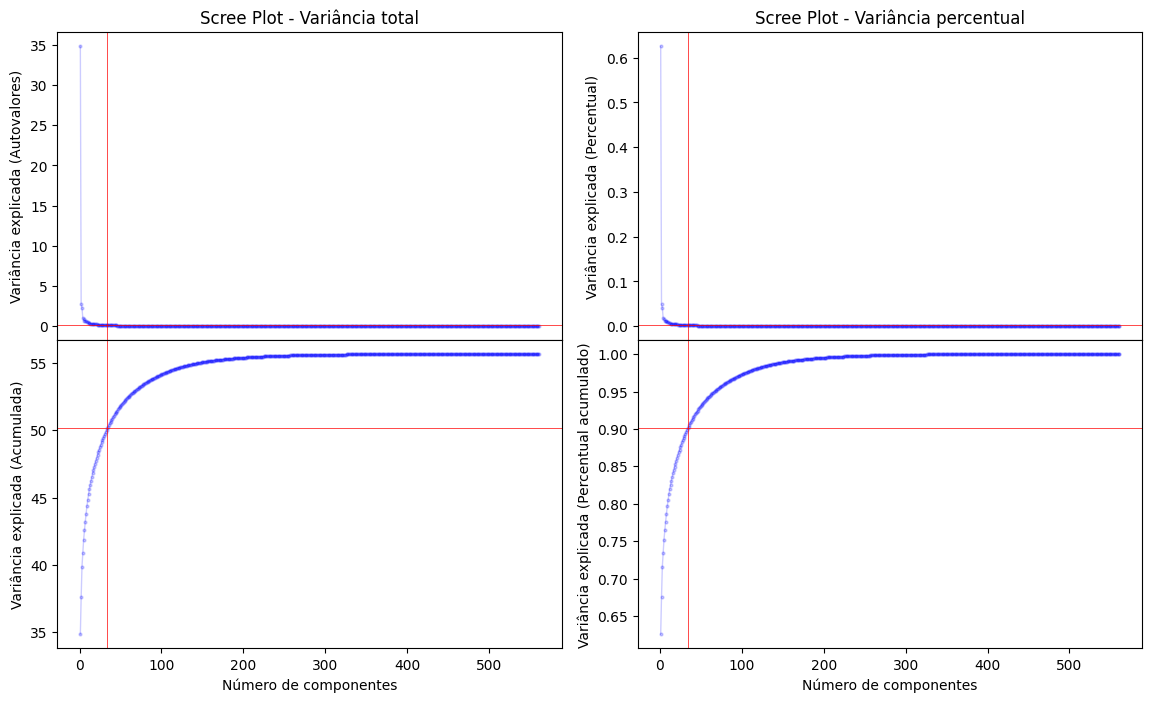

Para explicar 90% da variância sem a padronização das variáveis, são necessárias 34 componentes.


In [48]:
# Critério: Variância explicada

# Cria uma figura com 2 linhas e 2 colunas de subplots e ajusta o espaço entre eles
fig, ax = plt.subplots(nrows=2, ncols=2, sharex=True, figsize=(14, 8))
plt.subplots_adjust(hspace=0, wspace=.15)

# Número de componentes pelo critério
varexplicada = .90  # Define a variância explicada desejada
ncomp_criterio = (princomp.explained_variance_ratio_.cumsum() < varexplicada).sum() + 1
# Calcula o número de componentes necessário para atingir a variância explicada desejada

# Gráfico da variância nominal por quantidade de componentes
num_componentes = np.arange(princomp.n_components_) + 1
ax[0, 0].plot(num_componentes, princomp.explained_variance_, 'o-', linewidth=1, color='blue', markersize=2, alpha=.2)
ax[0 ,0].set_title('Scree Plot - Variância total')
ax[0, 0].set_xlabel('Número de componentes')
ax[0, 0].set_ylabel('Variância explicada (Autovalores)')

# Gráfico da variância nominal acumulada por quantidade de componentes
ax[1, 0].plot(num_componentes, princomp.explained_variance_.cumsum(), 'o-', linewidth=1, color='blue', markersize=2, alpha=.2)
ax[1, 0].set_xlabel('Número de componentes')
ax[1, 0].set_ylabel('Variância explicada (Acumulada)')

# Gráfico da variância percentual por quantidade de componentes
ax[0, 1].plot(num_componentes, princomp.explained_variance_ratio_, 'o-', linewidth=1, color='blue', markersize=2, alpha=.2)
ax[0, 1].set_title('Scree Plot - Variância percentual')
ax[0, 1].set_xlabel('Número de componentes')
ax[0, 1].set_ylabel('Variância explicada (Percentual)')

# Gráfico da variância percentual acumulada por quantidade de componentes
ax[1, 1].plot(num_componentes, princomp.explained_variance_ratio_.cumsum(), 'o-', linewidth=1, color='blue', markersize=2, alpha=.2)
ax[1, 1].set_xlabel('Número de componentes')
ax[1, 1].set_ylabel('Variância explicada (Percentual acumulado)')

# Linhas verticais de referência
ax[0, 0].axvline(x=ncomp_criterio, color='r', linestyle='-', linewidth=.5)
ax[1, 1].axvline(x=ncomp_criterio, color='r', linestyle='-', linewidth=.5)
ax[1, 0].axvline(x=ncomp_criterio, color='r', linestyle='-', linewidth=.5)
ax[0, 1].axvline(x=ncomp_criterio, color='r', linestyle='-', linewidth=.5)

# Linhas horizontais de referência
ax[0, 0].axhline(y=princomp.explained_variance_[ncomp_criterio-1], color='r', linestyle='-', linewidth=.5)
ax[1, 0].axhline(y=princomp.explained_variance_.cumsum()[ncomp_criterio-1], color='r', linestyle='-', linewidth=.5)
ax[0, 1].axhline(y=princomp.explained_variance_ratio_[ncomp_criterio-1], color='r', linestyle='-', linewidth=.5)
ax[1, 1].axhline(y=princomp.explained_variance_ratio_.cumsum()[ncomp_criterio-1], color='r', linestyle='-', linewidth=.5)

plt.show()

print(f'Para explicar 90% da variância sem a padronização das variáveis, são necessárias {ncomp_criterio} componentes.')

In [49]:
variancia = princomp.explained_variance_[ncomp_criterio - 1]
variancia_acumulada = princomp.explained_variance_.cumsum()[ncomp_criterio - 1]
pct_variancia = princomp.explained_variance_ratio_[ncomp_criterio - 1]
pct_variancia_acumulada = princomp.explained_variance_ratio_.cumsum()[ncomp_criterio - 1]

print(f'Número de componentes:{ncomp_criterio}')

print(f'Variância da última CP: {variancia:.2f}')
print(f'Variância acumulada da última CP: {variancia_acumulada:.2f}')
print(f'Variância percentual da última CP: {100*pct_variancia:.2f}%')
print(f'Variância percentual acumulada da última CP: {100*pct_variancia_acumulada:.2f}%')

Número de componentes:34
Variância da última CP: 0.13
Variância acumulada da última CP: 50.15
Variância percentual da última CP: 0.24%
Variância percentual acumulada da última CP: 90.09%


In [50]:
pca_raw = pd.DataFrame(data={'variancia': princomp.explained_variance_[:ncomp_criterio],
                             'variancia_acumulada': princomp.explained_variance_.cumsum()[:ncomp_criterio],
                             'pct_variancia': princomp.explained_variance_ratio_[:ncomp_criterio],
                             'pct_variancia_acumulada': princomp.explained_variance_ratio_.cumsum()[:ncomp_criterio]},
                       index=list(range(1, ncomp_criterio+1)))
pca_raw.index.name = 'CP'
pca_raw

,variancia,variancia_acumulada,pct_variancia,pct_variancia_acumulada
CP,,,,
1,34.823630,34.823630,0.625544,0.625544
2,2.735046,37.558677,0.049130,0.674675
3,2.294393,39.853070,0.041215,0.715889
4,1.043775,40.896845,0.018750,0.734639
5,0.943517,41.840362,0.016949,0.751587
6,0.708152,42.548514,0.012721,0.764308
7,0.655053,43.203567,0.011767,0.776075
8,0.595090,43.798657,0.010690,0.786765
9,0.539647,44.338304,0.009694,0.796459


PCA com padronização

In [51]:
pca_pad = PCA()
# Cria uma instância do objeto PCA, que será usado para realizar a análise de componentes principais

princomp_pad = pca_pad.fit(X_train_pad)
# Ajusta o PCA aos dados de treinamento para extrair as componentes principais

componentes_pad = princomp_pad.transform(X_train_pad)
# Transforma os dados de treinamento nas componentes principais

n_componentes_pad = X_train_pad.shape[1]
# Obtém o número de colunas dos dados de treinamento

nomes_pca_pad = ['CP' + str(x+1) for x in list(range(n_componentes_pad))]
# Cria uma lista de nomes para as componentes principais (CP1, CP2, CP3, ...)

pd.DataFrame(data=componentes_pad, columns=nomes_pca_pad)
# Visualiza o DataFrame com os dados transformados (componentes) e atribui os nomes_pca como nomes de colunas

,CP1,CP2,CP3,CP4,CP5,CP6,CP7,CP8,CP9,CP10,...,CP552,CP553,CP554,CP555,CP556,CP557,CP558,CP559,CP560,CP561
0,-16.137446,2.151878,3.144566,-0.272446,6.798476,-4.249105,2.936959,-4.905079,-0.775462,-3.627490,...,2.229812e-17,-4.739070e-16,8.999183e-17,-1.894375e-16,-7.140373e-17,5.164284e-17,-1.471356e-16,1.840855e-17,4.957448e-15,-3.460216e-16
1,-15.295154,1.387049,-0.682175,2.813486,4.265880,-2.055523,0.011204,-1.845860,0.492513,-0.180162,...,-3.275833e-16,1.523676e-18,-7.285452e-17,1.941602e-16,-1.336415e-16,3.794217e-17,8.092806e-17,-6.010147e-17,-7.614209e-16,3.023353e-16
2,-15.135989,2.473183,-1.756521,3.717722,4.181273,-1.357425,0.072942,-1.388094,0.539717,-0.671666,...,-1.419148e-16,8.675175e-17,-8.315142e-17,1.577885e-16,1.701729e-16,-2.298117e-16,-4.792719e-16,-1.566884e-17,-3.272938e-15,4.063014e-17
3,-15.349840,3.915414,-1.790201,2.567347,3.205621,-0.942880,0.530700,-1.832060,1.071444,-1.496887,...,2.672547e-17,-2.121543e-16,-3.856394e-16,1.570934e-16,-4.067373e-16,3.576900e-17,-4.744167e-16,-1.903323e-16,-6.457022e-16,-1.148727e-16
4,-15.543756,4.598424,-2.188433,2.897381,3.079941,-1.061386,-1.048520,-0.816877,0.600022,1.118799,...,-2.783091e-17,3.816430e-16,-4.025376e-16,3.136307e-16,-8.166578e-17,-8.542124e-18,-2.379606e-17,-6.103379e-17,-2.848513e-15,1.765876e-16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7347,15.464009,-12.535453,1.999041,3.457489,-1.523091,-2.698944,-3.561009,2.418529,0.383154,1.308633,...,-3.743312e-16,1.569194e-16,1.685714e-16,-3.599487e-16,1.171363e-16,-3.398971e-16,-2.407298e-16,5.368850e-17,-5.275977e-15,3.597164e-16
7348,14.221755,-10.252804,2.377499,2.802476,-1.325223,-4.345821,-2.193817,0.032138,-0.528893,0.702462,...,2.975874e-16,-6.141995e-17,-1.239823e-16,1.544043e-16,2.787481e-16,-2.053497e-16,-2.944162e-16,-5.983296e-17,-3.398478e-15,5.223499e-16
7349,14.332461,-12.259878,4.025672,3.849518,-2.860295,-3.623803,-3.929374,-0.873103,-0.746280,-1.575419,...,2.615520e-18,2.589568e-17,-2.246664e-16,-7.451618e-17,2.541458e-16,3.520356e-17,-6.512063e-17,1.262042e-16,8.335097e-16,7.661691e-16
7350,12.875143,-14.070299,2.915863,5.013085,-3.937957,-2.137461,-5.390033,0.321283,-0.916237,-1.646259,...,-2.039575e-16,-1.771094e-17,-2.693419e-17,9.010825e-17,1.266930e-16,5.857336e-17,2.142399e-16,-6.983377e-17,3.883012e-15,3.377711e-16


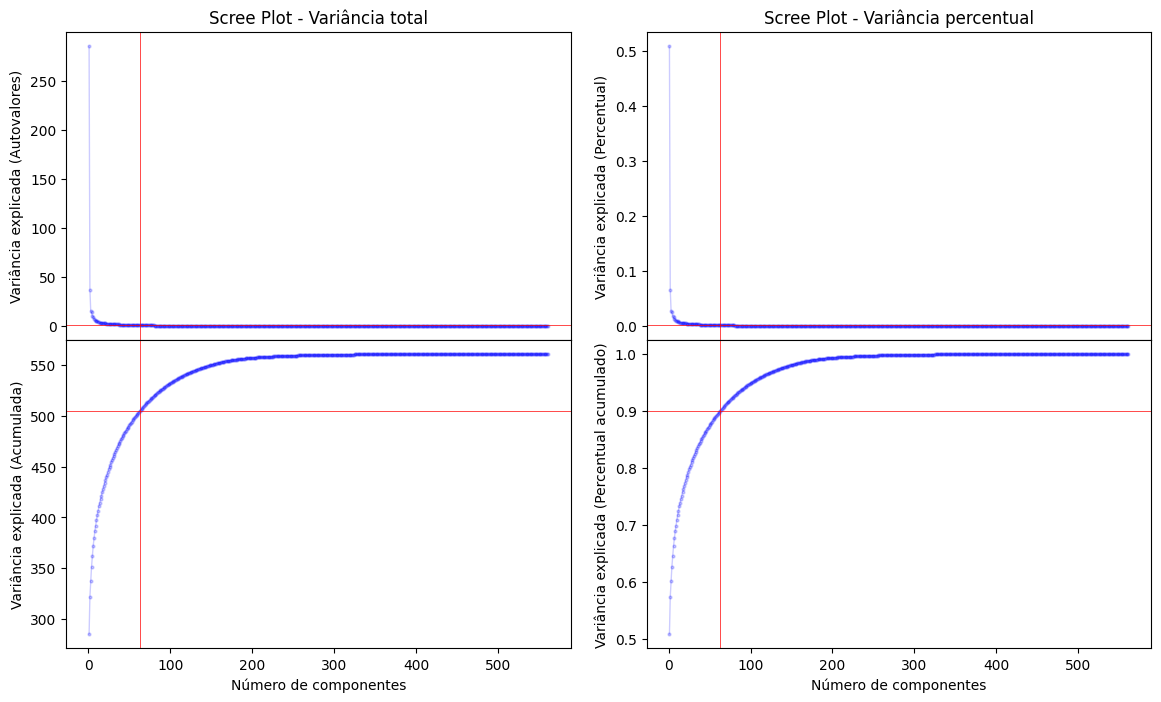

Para explicar 90% da variância com a padronização das variáveis, são necessárias 63 componentes.
Para o critério de autovalor > 1, são necessárias 61 componentes.


In [52]:
# Critério: Variância explicada
# Cria uma figura com 2 linhas e 2 colunas de subplots e ajusta o espaço entre eles
fig, ax = plt.subplots(nrows=2, ncols=2, sharex=True, figsize=(14, 8))
plt.subplots_adjust(hspace=0, wspace=.15)

# Número de componentes pelo critério
varexplicada = .90  # Define a variância explicada desejada
ncomp_criterio_pad = (princomp_pad.explained_variance_ratio_.cumsum() < varexplicada).sum() + 1
# Calcula o número de componentes necessário para atingir a variância explicada desejada

# Gráfico da variância nominal por quantidade de componentes
num_componentes_pad = np.arange(princomp_pad.n_components_) + 1
ax[0, 0].plot(num_componentes_pad, princomp_pad.explained_variance_, 'o-', linewidth=1, color='blue', markersize=2, alpha=.2)
ax[0 ,0].set_title('Scree Plot - Variância total')
ax[0, 0].set_xlabel('Número de componentes')
ax[0, 0].set_ylabel('Variância explicada (Autovalores)')

# Gráfico da variância nominal acumulada por quantidade de componentes
ax[1, 0].plot(num_componentes_pad, princomp_pad.explained_variance_.cumsum(), 'o-', linewidth=1, color='blue', markersize=2, alpha=.2)
ax[1, 0].set_xlabel('Número de componentes')
ax[1, 0].set_ylabel('Variância explicada (Acumulada)')

# Gráfico da variância percentual por quantidade de componentes
ax[0, 1].plot(num_componentes_pad, princomp_pad.explained_variance_ratio_, 'o-', linewidth=1, color='blue', markersize=2, alpha=.2)
ax[0, 1].set_title('Scree Plot - Variância percentual')
ax[0, 1].set_xlabel('Número de componentes')
ax[0, 1].set_ylabel('Variância explicada (Percentual)')

# Gráfico da variância percentual acumulada por quantidade de componentes
ax[1, 1].plot(num_componentes_pad, princomp_pad.explained_variance_ratio_.cumsum(), 'o-', linewidth=1, color='blue', markersize=2, alpha=.2)
ax[1, 1].set_xlabel('Número de componentes')
ax[1, 1].set_ylabel('Variância explicada (Percentual acumulado)')

# Linhas verticais de referência
ax[0, 0].axvline(x=ncomp_criterio_pad, color='r', linestyle='-', linewidth=.5)
ax[1, 1].axvline(x=ncomp_criterio_pad, color='r', linestyle='-', linewidth=.5)
ax[1, 0].axvline(x=ncomp_criterio_pad, color='r', linestyle='-', linewidth=.5)
ax[0, 1].axvline(x=ncomp_criterio_pad, color='r', linestyle='-', linewidth=.5)

# Linhas horizontais de referência
ax[0, 0].axhline(y=princomp_pad.explained_variance_[ncomp_criterio_pad-1], color='r', linestyle='-', linewidth=.5)
ax[1, 0].axhline(y=princomp_pad.explained_variance_.cumsum()[ncomp_criterio_pad-1], color='r', linestyle='-', linewidth=.5)
ax[0, 1].axhline(y=princomp_pad.explained_variance_ratio_[ncomp_criterio_pad-1], color='r', linestyle='-', linewidth=.5)
ax[1, 1].axhline(y=princomp_pad.explained_variance_ratio_.cumsum()[ncomp_criterio_pad-1], color='r', linestyle='-', linewidth=.5)

plt.show()

print(f'Para explicar 90% da variância com a padronização das variáveis, são necessárias {ncomp_criterio_pad} componentes.')

criterio_autovalor = (princomp_pad.explained_variance_ratio_ > 1 / princomp_pad.n_components_).sum()
print(f'Para o critério de autovalor > 1, são necessárias {criterio_autovalor} componentes.')

In [53]:
variancia = princomp_pad.explained_variance_[ncomp_criterio_pad - 1]
variancia_acumulada = princomp_pad.explained_variance_.cumsum()[ncomp_criterio_pad - 1]
pct_variancia = princomp_pad.explained_variance_ratio_[ncomp_criterio_pad - 1]
pct_variancia_acumulada = princomp_pad.explained_variance_ratio_.cumsum()[ncomp_criterio_pad - 1]

print(f'Número de componentes: {ncomp_criterio_pad}')

print(f'Variância da última CP: {variancia:.2f}')
print(f'Variância acumulada da última CP: {variancia_acumulada:.2f}')
print(f'Variância percentual da última CP: {100*pct_variancia:.2f}%')
print(f'Variância percentual acumulada da última CP: {100*pct_variancia_acumulada:.2f}%')

Número de componentes: 63
Variância da última CP: 0.99
Variância acumulada da última CP: 505.20
Variância percentual da última CP: 0.18%
Variância percentual acumulada da última CP: 90.05%


In [54]:
pca_pad = pd.DataFrame(data={'variancia': princomp_pad.explained_variance_[:ncomp_criterio_pad],
                             'variancia_acumulada': princomp_pad.explained_variance_.cumsum()[:ncomp_criterio_pad],
                             'pct_variancia': princomp_pad.explained_variance_ratio_[:ncomp_criterio_pad],
                             'pct_variancia_acumulada': princomp_pad.explained_variance_ratio_.cumsum()[:ncomp_criterio_pad]},
                       index=list(range(1, ncomp_criterio_pad+1)))
pca_pad.index.name = 'CP'
pca_pad

,variancia,variancia_acumulada,pct_variancia,pct_variancia_acumulada
CP,,,,
1,284.882377,284.882377,0.507812,0.507812
2,36.917616,321.799993,0.065807,0.573619
3,15.744110,337.544103,0.028064,0.601683
4,14.047175,351.591278,0.025040,0.626722
5,10.593279,362.184557,0.018883,0.645605
...,...,...,...,...
59,1.055044,501.154215,0.001881,0.893323
60,1.044672,502.198886,0.001862,0.895185
61,1.018027,503.216914,0.001815,0.897000


## Árvore com PCA

Faça duas uma árvore de decisão com 10 componentes principais - uma com base em dados padronizados e outra sem padronizar. Utilize o ```ccp_alpha=0.001```.

Compare a acurácia na base de treino e teste.

In [55]:
%%time

# Aplica o PCA com 10 componentes aos dados de treinamento SEM padronização
prcomp = PCA(n_components=10).fit(X_train)

# Transforma os dados de treinamento e teste utilizando as componentes principais encontradas pelo PCA
pc_treino = prcomp.transform(X_train)
pc_teste  = prcomp.transform(X_test)

# Imprime a forma dos dados de treinamento e teste após a transformação
print(f'Dimensões da base de treinamento: {pc_treino.shape}')
print(f'Dimensões da base de teste: {pc_teste.shape}\n')

# Inicializa um classificador de árvore de decisão com ccp_alpha=0.001 e treina-o com os dados de treinamento transformados
clf = DecisionTreeClassifier(ccp_alpha=0.001)
clf.fit(pc_treino, y_train)

# Calcula e imprime a acurácia do classificador nos dados de treinamento e teste
print(f'Acurácia na base de treinamento: {clf.score(pc_treino, y_train)}')
print(f'Acurácia na base de teste: {clf.score(pc_teste, y_test)}\n')

Dimensões da base de treinamento: (7352, 10)
Dimensões da base de teste: (2947, 10)

Acurácia na base de treinamento: 0.8924102285092492
Acurácia na base de teste: 0.8238887003732609

CPU times: user 904 ms, sys: 459 ms, total: 1.36 s
Wall time: 1.27 s


In [56]:
%%time

# Aplica o PCA com 10 componentes aos dados de treinamento COM padronização
prcomp_pad = PCA(n_components=10).fit(X_train_pad)

# Transforma os dados de treinamento e teste utilizando as componentes principais encontradas pelo PCA
pc_treino_pad = prcomp_pad.transform(X_train_pad)
pc_teste_pad  = prcomp_pad.transform(X_test_pad)

# Imprime a forma dos dados de treinamento e teste após a transformação
print(f'Dimensões da base de treinamento: {pc_treino_pad.shape}')
print(f'Dimensões da base de teste: {pc_teste_pad.shape}\n')

# Inicializa um classificador de árvore de decisão com ccp_alpha=0.001 e treina-o com os dados de treinamento transformados
clf_pad = DecisionTreeClassifier(ccp_alpha=0.001)
clf_pad.fit(pc_treino_pad, y_train)

# Calcula e imprime a acurácia do classificador nos dados de treinamento e teste
print(f'Acurácia na base de treinamento: {clf_pad.score(pc_treino_pad, y_train)}')
print(f'Acurácia na base de teste: {clf_pad.score(pc_teste_pad, y_test)}\n')

Dimensões da base de treinamento: (7352, 10)
Dimensões da base de teste: (2947, 10)

Acurácia na base de treinamento: 0.8585418933623504
Acurácia na base de teste: 0.7770614183915847

CPU times: user 887 ms, sys: 643 ms, total: 1.53 s
Wall time: 835 ms


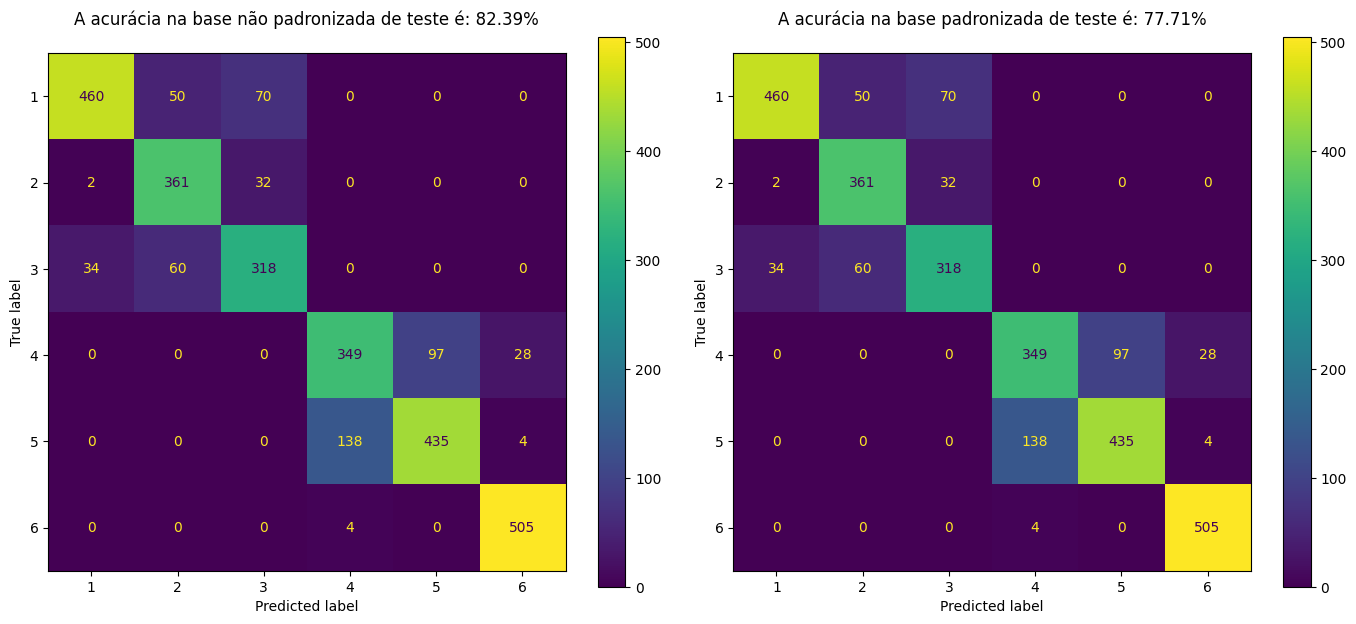

In [57]:
# Realiza a previsão dos dados
y_pred = clf.predict(pc_teste)
y_pred_pad = clf_pad.predict(pc_teste_pad)

# Cria uma figura com 1 linha e 2 colunas e define o tamanho da figura
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

# Configura o título do primeiro subgráfico com a acurácia na base não padronizada de teste
ax[0].set_title(f'A acurácia na base não padronizada de teste é: {accuracy_score(y_pred, y_test) * 100:.2f}%\n')

# Plota a matriz de confusão do primeiro subgráfico
ConfusionMatrixDisplay.from_predictions(y_pred, y_test, ax=ax[0])

# Configura o título do segundo subgráfico com a acurácia na base padronizada de teste
ax[1].set_title(f'A acurácia na base padronizada de teste é: {accuracy_score(y_pred_pad, y_test) * 100:.2f}%\n')

# Plota a matriz de confusão do segundo subgráfico
ConfusionMatrixDisplay.from_predictions(y_pred, y_test, ax=ax[1])

# Ajusta o layout dos subgráficos para evitar sobreposições
plt.tight_layout()

# Exibe o gráfico
plt.show()